In [1]:
options(java.parameters = "-Xmx8g")
library(bartMachine)

Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: missForest
Loading required package: foreach
Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.3! You have 7.64GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM before you call
'library(bartMachine)'.



In [5]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ tidyr::unpack()     masks Matrix::unpack()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



# BART with 5 Predictors

In [6]:
## Functions used to generate fake data
set.seed(42)
f_fried <- function(x) 10 * sin(pi * x[,1] * x[,2]) + 20 * (x[,3] - 0.5)^2 + 
                      10 * x[,4] + 5 * x[,5]
    
gen_data <- function(n_train, n_test, P, sigma) {
    X <- matrix(runif(n_train * P), nrow = n_train)
    mu <- f_fried(X)
    X_test <- matrix(runif(n_test * P), nrow = n_test)
    mu_test <- f_fried(X_test)
    Y <- mu + sigma * rnorm(n_train)
    Y_test <- mu_test + sigma * rnorm(n_test)
        
    return(list(X = X, Y = Y, mu = mu, X_test = X_test, Y_test = Y_test, mu_test = mu_test))
}

## Simiulate dataset
sim_data <- gen_data(250, 100, 5, 1)

In [7]:
sim_data$X %>% head
sim_data$Y %>% head

[,1]      [,2]       [,3]      [,4]       [,5]      
[1,] 0.9148060 0.33423133 0.1365052 0.24492099 0.84829322
[2,] 0.9370754 0.18843433 0.1771364 0.08763591 0.06274633
[3,] 0.2861395 0.26971618 0.5195605 0.39110850 0.81984509
[4,] 0.8304476 0.53074408 0.8111208 0.18256143 0.53936029
[5,] 0.6417455 0.02145023 0.1153620 0.13362478 0.49902010
[6,] 0.5190959 0.79876031 0.8934218 0.25746291 0.02222732

[1] 16.554997  7.722252 11.781766 17.247000  6.338875 14.523815

In [8]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators


[1] 16


In [47]:
set_bart_machine_num_cores(n_cores)
t.start <- Sys.time()
sim.bm <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine now using 16 cores.
bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 6 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 2.383111 secs


In [47]:
sim.bm %>% summary

bartMachine v1.2.3 for regression

training data n = 250 and p = 5 
built in 1.8 secs on 16 cores, 50 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 6.669 
avg sigsq estimate after burn-in: 0.9155 

in-sample statistics:
 L1 = 128.95 
 L2 = 105.62 
 rmse = 0.65 
 Pseudo-Rsq = 0.9836
p-val for shapiro-wilk test of normality of residuals: 0.71078 
p-val for zero-mean noise: 0.35537 



In [39]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [52]:
rmse(sim_data$Y_test, predict(sim.bm, sim_data$X_test %>% data.frame))

[1] 1.319237

In [54]:
sim.bm %>% check_bart_error_assumptions

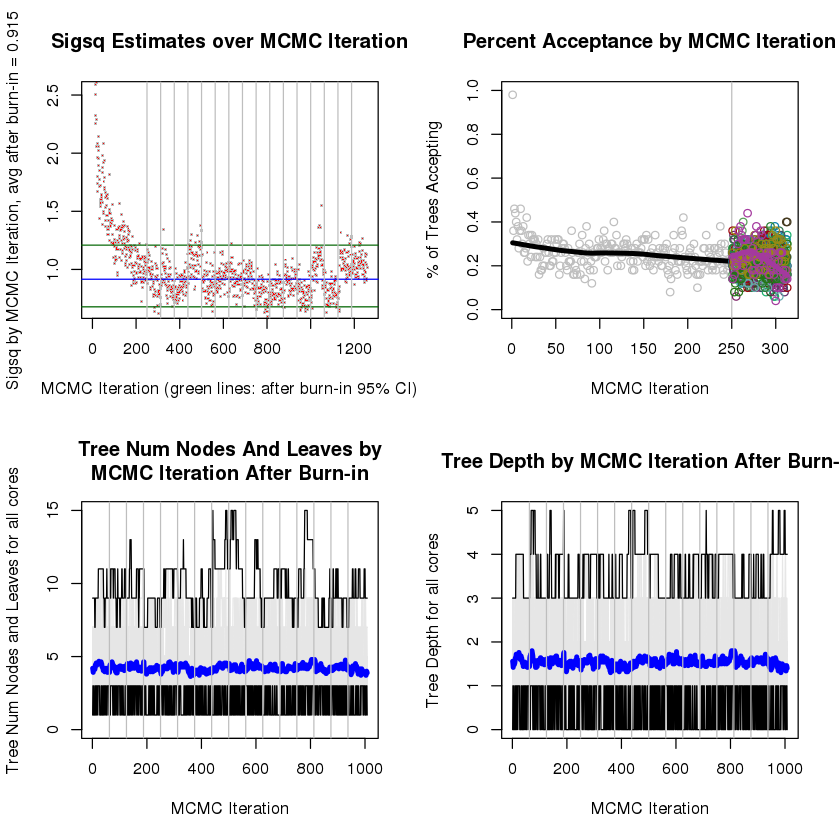

In [53]:
sim.bm %>% plot_convergence_diagnostics

In [55]:
saveRDS(sim.bm,"model_files/simbm_model_v1_20191124.RDS")
sim.bm.read <- readRDS("model_files/simbm_model_v1_20191124.RDS")

## SoftBART

In [1]:
library(SoftBart)

Loading required package: scales
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 3.0-1

Loading required package: Rcpp


In [18]:
softbart_fit_1

$y_hat_train
            [,1]      [,2]      [,3]     [,4]     [,5]     [,6]      [,7]
   [1,] 17.50905  8.947202 10.091547 16.90651 8.175949 15.68027 10.636476
   [2,] 17.91003  9.029923 11.729291 17.28925 7.709438 15.60594 11.378496
   [3,] 17.71228  8.483758 11.766945 17.39349 6.727922 15.19700 11.404815
   [4,] 17.30217  8.431760 10.830320 17.66536 7.429923 15.50432 11.182690
   [5,] 17.47775  9.314818 11.544930 17.28027 6.434061 15.37686 10.745383
   [6,] 17.06201  8.625283 11.264513 17.12391 7.626944 14.81501 11.100180
   [7,] 17.51017  8.423284 12.183651 16.76489 7.826560 15.67502 11.396483
   [8,] 16.83268  8.457659 10.797899 16.78185 6.873573 15.30140 11.128333
   [9,] 16.32785  8.070053 10.806456 17.16750 7.114296 15.66668 11.424686
  [10,] 17.83753  8.292629 11.508693 17.00567 6.660456 15.20216 11.727045
  [11,] 17.46384  8.643570 10.561117 17.16410 7.185026 15.23674 11.055796
  [12,] 17.35640  8.459127 10.703113 17.52260 7.033452 15.50460 11.444461
  [13,] 17.27466  8.95452

Finishing warmup 100 Number of trees = 50
Finishing warmup 200 Number of trees = 50
Finishing warmup 300 Number of trees = 50
Finishing warmup 400 Number of trees = 50
Finishing warmup 500 Number of trees = 50
Finishing warmup 600 Number of trees = 50
Finishing warmup 700 Number of trees = 50
Finishing warmup 800 Number of trees = 50
Finishing warmup 900 Number of trees = 50
Finishing warmup 1000 Number of trees = 50
Finishing warmup 1100 Number of trees = 50
Finishing warmup 1200 Number of trees = 50
Finishing warmup 1300 Number of trees = 50
Finishing warmup 1400 Number of trees = 50
Finishing warmup 1500 Number of trees = 50
Finishing warmup 1600 Number of trees = 50
Finishing warmup 1700 Number of trees = 50
Finishing warmup 1800 Number of trees = 50
Finishing warmup 1900 Number of trees = 50
Finishing warmup 2000 Number of trees = 50
Finishing warmup 2100 Number of trees = 50
Finishing warmup 2200 Number of trees = 50
Finishing warmup 2300 Number of trees = 50
Finishing warmup 240

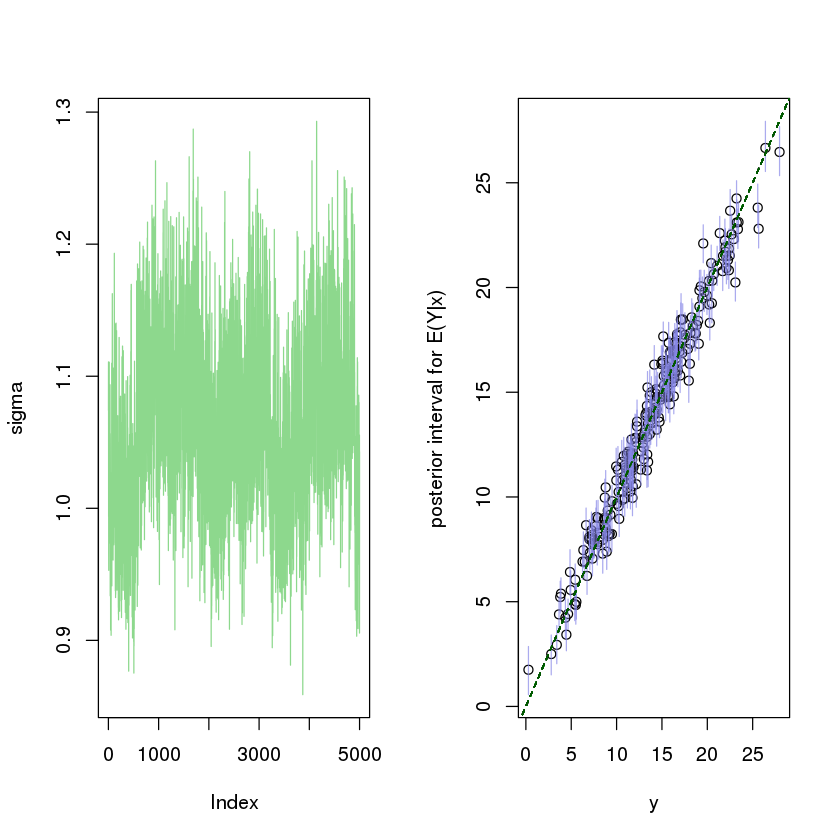

In [9]:
## Fit the models
softbart_fit_1 <- softbart(X = sim_data$X, Y = sim_data$Y, X_test = sim_data$X_test, 
                hypers = Hypers(sim_data$X, sim_data$Y, num_tree = 50, temperature = 1),
                opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

plot(softbart_fit_1)

[1] 1.231231

[1] 0.9086065

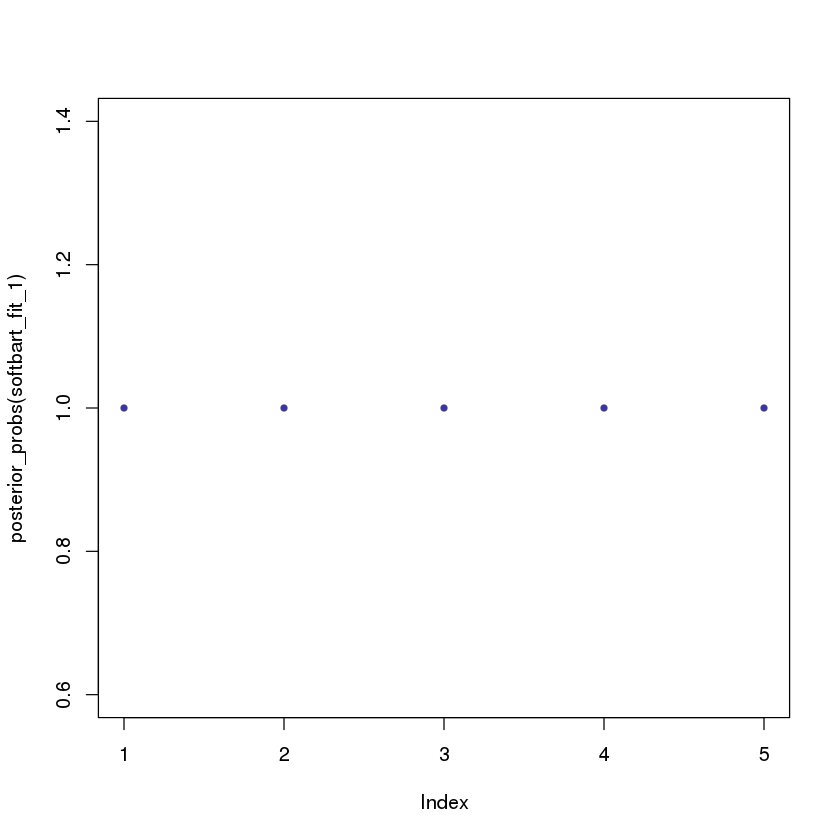

In [13]:
## Look at posterior model inclusion probabilities for each predictor. 

posterior_probs <- function(fit) colMeans(fit$var_counts > 0)
plot(posterior_probs(softbart_fit_1), 
     col = ifelse(posterior_probs(softbart_fit_1) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

rmse(softbart_fit_1$y_hat_test_mean, sim_data$Y_test)
rmse(softbart_fit_1$y_hat_train_mean, sim_data$Y)

In [15]:
saveRDS(softbart_fit_1,file = "model_files/softbart_model_20191124")

In [16]:
softbart_fit_1.read = readRDS("model_files/softbart_model_20191124")

## Softbart fit 2

ERROR: Error in mean((x - y)^2): object 'sim_data_1' not found


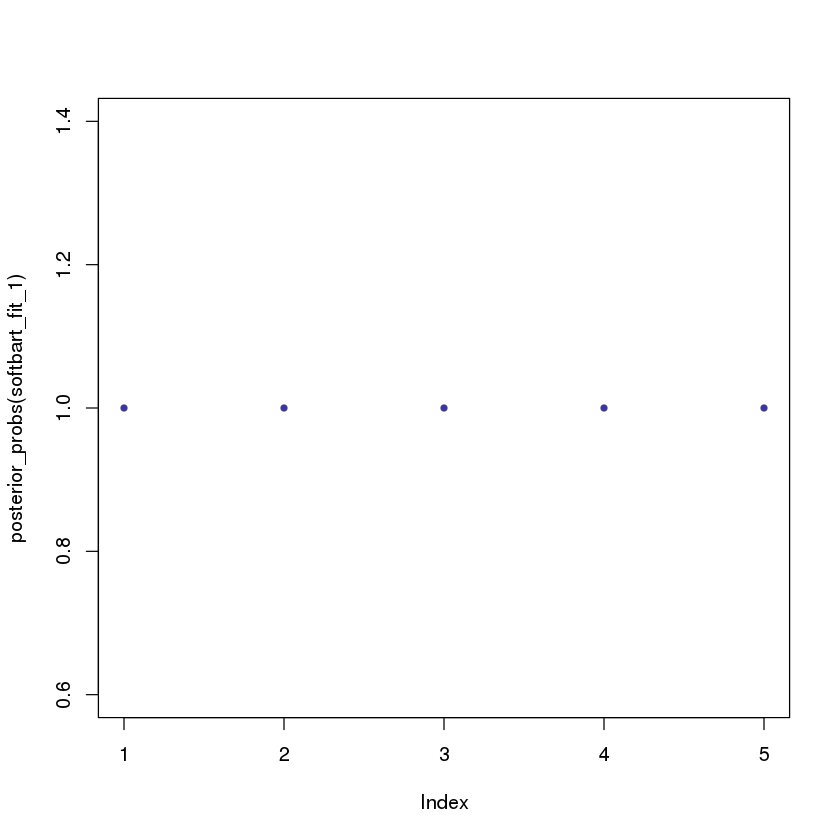

In [10]:

## Fit the model
softbart_fit_2 <- softbart(X = sim_data_2$X, Y = sim_data_2$Y, X_test = sim_data_2$X_test, 
                           hypers = Hypers(sim_data_2$X, sim_data_2$Y, num_tree = 50, temperature = 1),
                           opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

## Plot the fit (note: interval estimates are not prediction intervals, 
## so they do not cover the predictions at the nominal rate)
plot(softbart_fit_2)
softbart_fit_1$y_hat_test_mean
## Look at posterior model inclusion probabilities for each predictor. 

plot(posterior_probs(softbart_fit_2), 
     col = ifelse(posterior_probs(fit) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

rmse(softbart_fit_2$y_hat_test_mean, sim_data_2$mu_test)
rmse(softbart_fit_2$y_hat_train_mean, sim_data_2$mu)